In [1]:
#Pandapower & other data processing stuff
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
# import pandapower.toolbox as tb
# import pandapower.timeseries as ts
# import pandapower.control as control
# from pandapower.control.controller.const_control import ConstControl
# from pandapower.timeseries.data_sources.frame_data import DFData
# from pandapower.timeseries.output_writer import OutputWriter
# from pandapower.timeseries.run_time_series import run_timeseries
# from pandapower.control.basic_controller import Controller
#  import simbench as sb

import matplotlib.pyplot as plt
import numpy as np
import random


# import stable_baselines3 as sb3


In [24]:
import gurobipy as gp
from gurobipy import GRB
import math
import grid_loader as gl
import pandas as pd
import numpy as np
from Matpower.powerNetwork import Input, get_rateA

"""Set"""
# Componets of Grid
net = gl.load_test_case_grid(14)
generators = net.gen["bus"].to_list()
ext_grid = net.ext_grid["bus"].to_list()
buses = net.bus.index
loads = net.load["bus"].to_list()
lines = []
for i in net.line.index:
    lines.append((net.line.loc[i, "from_bus"], net.line.loc[i, "to_bus"]))


time_periods = range(0, 24) # T
time_periods_plus = range(0, 25) # T+1

neighbors = {} # δ(i)
for line in lines:
    if line[0] not in neighbors:
        neighbors[line[0]] = [line[1]]
    else:
        neighbors[line[0]].append(line[1])

# Define parameters
df_load_p = pd.read_csv("../Evaluation/Case14_EV/load_p.csv").transpose()
df_load_q = pd.read_csv("../Evaluation/Case14_EV/load_q.csv").transpose()

df_load_p["bus"] = loads
df_load_q["bus"] = loads

P_D = {}
Q_D = {}
for i in buses:
    if i in loads:
        P_D[i] = df_load_p[df_load_p["bus"] == 1].drop("bus", axis=1).values[0].tolist()
        Q_D[i] = df_load_q[df_load_q["bus"] == i].drop("bus", axis=1).values[0].tolist()
    else:
        P_D[i] = [0] * len(time_periods)
        Q_D[i] = [0] * len(time_periods)


df_renewable = pd.read_csv("../Evaluation/Case14_EV/renewable.csv").transpose()
df_renewable["bus"] = generators
P_renew = {}
for i in buses:
    if i in generators:
        P_renew[i] = df_renewable[df_renewable["bus"] == i].drop("bus", axis=1).values[0].tolist()
    else:
        P_renew[i] = [0] * len(time_periods)

PG_min = {}
PG_max = {}
QG_min = {}
QG_max = {}
for i in buses:
    if i in generators:
        PG_min[i] = net.gen.loc[net.gen["bus"]==i, "min_p_mw"].values[0]
        PG_max[i] = net.gen.loc[net.gen["bus"]==i, "max_p_mw"].values[0]
        QG_min[i] = net.gen.loc[net.gen["bus"]==i, "min_q_mvar"].values[0]
        QG_max[i] = net.gen.loc[net.gen["bus"]==i, "max_q_mvar"].values[0]
    else:
        PG_min[i] = 0
        PG_max[i] = 0
        QG_min[i] = 0
        QG_max[i] = 0

Pex_min = {}
Pex_max = {}
Qex_min = {}
Qex_max = {}
for i in buses:
    if i in ext_grid:
        Pex_min[i] = net.ext_grid.loc[net.ext_grid["bus"]==i, "min_p_mw"].values[0]
        Pex_max[i] = net.ext_grid.loc[net.ext_grid["bus"]==i, "max_p_mw"].values[0]
        Qex_min[i] = net.ext_grid.loc[net.ext_grid["bus"]==i, "min_q_mvar"].values[0]
        Qex_max[i] = net.ext_grid.loc[net.ext_grid["bus"]==i, "max_q_mvar"].values[0]
    else:
        Pex_min[i] = 0
        Pex_max[i] = 0
        Qex_min[i] = 0
        Qex_max[i] = 0

V_min = net.bus.loc[:, "min_vm_pu"].to_dict()
V_max = net.bus.loc[:, "max_vm_pu"].to_dict()
V_max_sqrt = {i: V_max[i]**2 for i in V_max}
V_max_sqrt_neg = {i: -V_max[i]**2 for i in V_max}

theta_max = 30 # maximum phase angle difference

# Get EV data
df_EV_spec = pd.read_csv("../Evaluation/Case14_EV/EV_spec.csv")
df_EV_SOC = pd.read_csv("../Evaluation/Case14_EV/ev_soc.csv").transpose()
df_EV_spec["bus"] = loads
df_EV_SOC["bus"] = loads
df_EV_spec["battery_capacity"] = df_EV_spec["max_e_mwh"]/df_EV_spec["n_car"]
C = {} # Battery capacity
eta_d = {} # Discharge efficiency
eta_c = {} # Charge efficiency
Z_init = {} # Initial SOC
for i in buses:
    if i in loads:
        C[i] = df_EV_spec.loc[df_EV_spec["bus"]==i, "battery_capacity"].values[0]
        eta_d[i] = df_EV_spec[df_EV_spec.loc[:, "bus"]==i]["eta_d"].values[0]
        eta_c[i] = df_EV_spec[df_EV_spec.loc[:, "bus"]==i]["eta_c"].values[0]
        Z_init[i] = df_EV_SOC[df_EV_SOC.loc[:, "bus"]==i][0].values[0]
    else:
        C[i] = 0
        eta_d[i] = 0
        eta_c[i] = 0
        Z_init[i] = 0


# Line data
net.line["admittance"] = net.line["parallel"]/net.line["length_km"]/(net.line["r_ohm_per_km"] + 1j*net.line["x_ohm_per_km"])
net.line["conductance"] = np.real(net.line["admittance"])
net.line["susceptance"] = np.imag(net.line["admittance"])
buses_data, lines_data, generators_data, costs_data = Input("Matpower/case14.m")
S_max = get_rateA(lines_data)


# Create a new model
model = gp.Model("Multi-Period OPF")

# Variables for generation (P_G for active power, Q_G for reactive power)
P_G = model.addVars(buses, time_periods, lb=PG_min, ub=PG_max, name="P_G")
Q_G = model.addVars(buses, time_periods, lb=QG_min, ub=QG_max, name="Q_G")

# Set generation to zero for non-generator buses
for i in buses:
    for t in time_periods:
        if i not in generators:
            P_G[i, t] = 0
            Q_G[i, t] = 0

# Voltage magnitude (V) and phase angle difference (theta)
V = model.addVars(buses, time_periods, lb=V_min, ub=V_max, name="V")
theta = model.addVars(buses, buses, time_periods, lb=0, ub=theta_max, name="theta")


# Cosine and sine related variables
cos = model.addVars(buses, buses, time_periods, name="cosine")
sin = model.addVars(buses, buses, time_periods, name="sine")
c_ijt = model.addVars(buses, buses, time_periods, lb=0, ub=V_max_sqrt, name="c_ijt")
s_ijt = model.addVars(buses, buses, time_periods, lb=V_max_sqrt_neg, ub=0, name="s_ijt")
v_sqrt = model.addVars(buses, buses, time_periods, lb=0, ub=V_max, name="v_sqrt")

# Set non-neighboring and non-self cosine and sine variables to zero
for i in buses:
    for j in buses:
        for t in time_periods:
            if i in neighbors and j not in neighbors[i] and j != i:
                c_ijt[i, j, t] = 0
                s_ijt[i, j, t] = 0

# State of Charge (SOC) variables
Z = model.addVars(buses, time_periods_plus, lb=0, ub=1, name="SOC")
# Set SOC to zero for non-load buses
for i in buses:
    for t in time_periods:
        if i not in loads:
            Z[i, t] = 0

# Charging and discharging power
P_c = model.addVars(buses, time_periods, ub=100, name="Charging")
P_d = model.addVars(buses, time_periods, ub=100, name="Discharging")
# TODO: adjust the ub and lb for charging and discharging power

# Set charging and discharging power to zero for non-EV buses (non-load buses)
for i in buses:
    for t in time_periods:
        if i not in loads:
            P_c[i, t] = 0
            P_d[i, t] = 0

# Variables for external grid (P_ex for active power, Q_ex for reactive power)
P_ex = model.addVars(ext_grid, time_periods, lb=Pex_min, ub=Pex_max, name="P_ex")
Q_ex = model.addVars(ext_grid, time_periods, lb=Qex_min, ub=Qex_max, name="Q_ex")

# Power flow variables
P_ijt = model.addVars(buses, buses, time_periods, name="P_ijt")
Q_ijt = model.addVars(buses, buses, time_periods, name="Q_ijt")

# Objective function
costfunction_generator = net.poly_cost[net.poly_cost["et"] == "gen"]
costfunction_extgrid = net.poly_cost[net.poly_cost["et"] == "ext_grid"]

obj = gp.quicksum(costfunction_generator.iat[i,4] * P_G[generators[i], t]**2 + costfunction_generator.iat[i,3] * P_G[generators[i], t] \
                  + costfunction_generator.iat[i,2] for i in range(len(generators)) for t in time_periods) + \
    gp.quicksum(costfunction_extgrid.iat[i,4] * P_ex[ext_grid[i], t]**2 + costfunction_extgrid.iat[i,3] * P_ex[ext_grid[i], t] \
                + costfunction_extgrid.iat[i,2] for i in range(len(ext_grid)) for t in time_periods)

model.setObjective(obj, GRB.MINIMIZE)

# Active power balance 3(a)
for i in buses:
    for t in time_periods:
        if i in neighbors:
            model.addConstr(
                P_G[i, t] - P_D[i][t] - P_c[i, t] + eta_d[i] * P_d[i, t] == gp.quicksum(P_ijt[i, j, t] for j in neighbors[i]),
                name=f"Power_balance_P_{i}_{t}"
            )
        else:
            model.addConstr(
                P_G[i, t] - P_D[i][t] - P_c[i, t] + eta_d[i] * P_d[i, t] == 0,
                name=f"Power_balance_P_{i}_{t}"
            )

# Reactive power balance 3(b)
for i in buses:
    for t in time_periods:
        if i in neighbors:
            for j in neighbors[i]:
                model.addConstr(
                    Q_G[i, t] - Q_D[i][t] == gp.quicksum(Q_ijt[i, j, t] for j in neighbors[i]),
                    name=f"Power_balance_Q_{i}_{t}"
                )
        else:
            model.addConstr(
                Q_G[i, t] - Q_D[i][t] == 0,
                name=f"Power_balance_Q_{i}_{t}"
            )
# Power flow constraints (3c and 3d)
for (i, j) in lines:
    for t in time_periods:
        model.addConstr(
            P_ijt[i, j, t] == net.line.loc[(net.line["from_bus"] == i) & (net.line["to_bus"] == j), "conductance"].values[0] * c_ijt[i, i, t]
                            + net.line.loc[(net.line["from_bus"] == i) & (net.line["to_bus"] == j), "conductance"].values[0] * c_ijt[i, j, t]
                            - net.line.loc[(net.line["from_bus"] == i) & (net.line["to_bus"] == j), "susceptance"].values[0] * s_ijt[i, j, t],
            name=f"Power_flow_P_{i}_{j}_{t}"
        )
        
        model.addConstr(
            Q_ijt[i, j, t] == - net.line.loc[(net.line["from_bus"] == i) & (net.line["to_bus"] == j), "susceptance"].values[0] * c_ijt[i, i, t]
                            - net.line.loc[(net.line["from_bus"] == i) & (net.line["to_bus"] == j), "susceptance"].values[0] * c_ijt[i, j, t]
                            - net.line.loc[(net.line["from_bus"] == i) & (net.line["to_bus"] == j), "conductance"].values[0] * s_ijt[i, j, t],
            name=f"Power_flow_Q_{i}_{j}_{t}"
        ) 
        
# Constraints to build up the cosine and sine variables
for i in buses:
    for j in buses:
        for t in time_periods: 
            model.addGenConstrCos(theta[i, j, t], cos[i, j, t])
            model.addGenConstrSin(theta[i, j, t], sin[i, j, t])
            model.addConstr(v_sqrt[i, j, t] == V[i, t] * V[j, t])
            model.addConstr(c_ijt[i, j, t] == v_sqrt[i, j, t] * cos[i, j, t])
            model.addConstr(s_ijt[i, j, t] == -1 * v_sqrt[i, j, t] * sin[i, j, t])


# Cosine variable constraints (3e)
for i in buses:
    for t in time_periods:
        model.addConstr(
            V_min[i]**2 <= c_ijt[i, i, t],
            name=f"cosine_lowerbound_{i}_{t}"
        )
        model.addConstr(
            c_ijt[i, i, t] <= V_max[i]**2,
            name=f"cosine_upperbound_{i}_{t}"
        )
    
# SOCP relaxation constraint (5)
for (i, j) in lines:
    for t in time_periods:
        model.addConstr(
            c_ijt[i, j, t] ** 2 + s_ijt[i, j, t] ** 2 <= c_ijt[i, i, t] * c_ijt[j, j, t],
            name=f"SOCP_{i}_{j}_{t}"
        )

# Generator constraints (1g and 1h)
for i in buses:
    for t in time_periods:
        model.addConstr(
            P_G[i, t] >= PG_min[i],
            name=f"PG_lowerbound_{i}_{t}"
        )
        model.addConstr(
            P_G[i, t] <= PG_max[i],
            name=f"PG_upperbound_{i}_{t}"
        )
        model.addConstr(
            Q_G[i, t] >= QG_min[i],
            name=f"QG_lowerbound_{i}_{t}"
        )
        model.addConstr(
            Q_G[i, t] <= QG_max[i],
            name=f"QG_upperbound_{i}_{t}"
        )

# Line loading constraints (1i)
for (i, j) in lines:
    for t in time_periods:
        model.addConstr(
            P_ijt[i, j, t] ** 2 + Q_ijt[i, j, t] ** 2 <= S_max[(i, j)],
            name=f"Line_loading_{i}_{j}_{t}"
        )

# Phase angle difference constraints (1j)
for i in buses:
    for j in buses:
        for t in time_periods:
            if i in neighbors and j in neighbors[i]:
                # Add the constraints for both positive and negative bounds
                model.addConstr(
                    theta[i, j, t] <= theta_max,
                    name=f"Phase_angle_diff_upper_{i}_{j}_{t}"
                )
                model.addConstr(
                    theta[i, j, t] >= -theta_max,
                    name=f"Phase_angle_diff_lower_{i}_{j}_{t}"
                )

# SOC balance equation (1k)
for i in buses:
    for t in time_periods:
        model.addConstr(
            Z[i, t+1] * C[i] == Z[i, t] * C[i] + eta_c[i] * P_c[i, t] - P_d[i, t],
            name=f"SOC_balance_{i}_{t}"
        )

# Initial SOC (1m)
for i in buses:
    model.addConstr(
        Z[i, 0] == Z_init[i],
        name=f"Initial_SOC_{i}"
    )

# Charging and discharging power constraints (1n and 1o)
for i in buses:
    for t in time_periods:
        model.addConstr(
            P_c[i, t] <= (1 - Z[i, t]) * C[i],
            name=f"Charging_power_{i}_{t}"
        )
        model.addConstr(
            P_d[i, t] <= Z[i, t] * C[i],
            name=f"Discharging_power_{i}_{t}"
        )

Text(0, 0.5, '%')

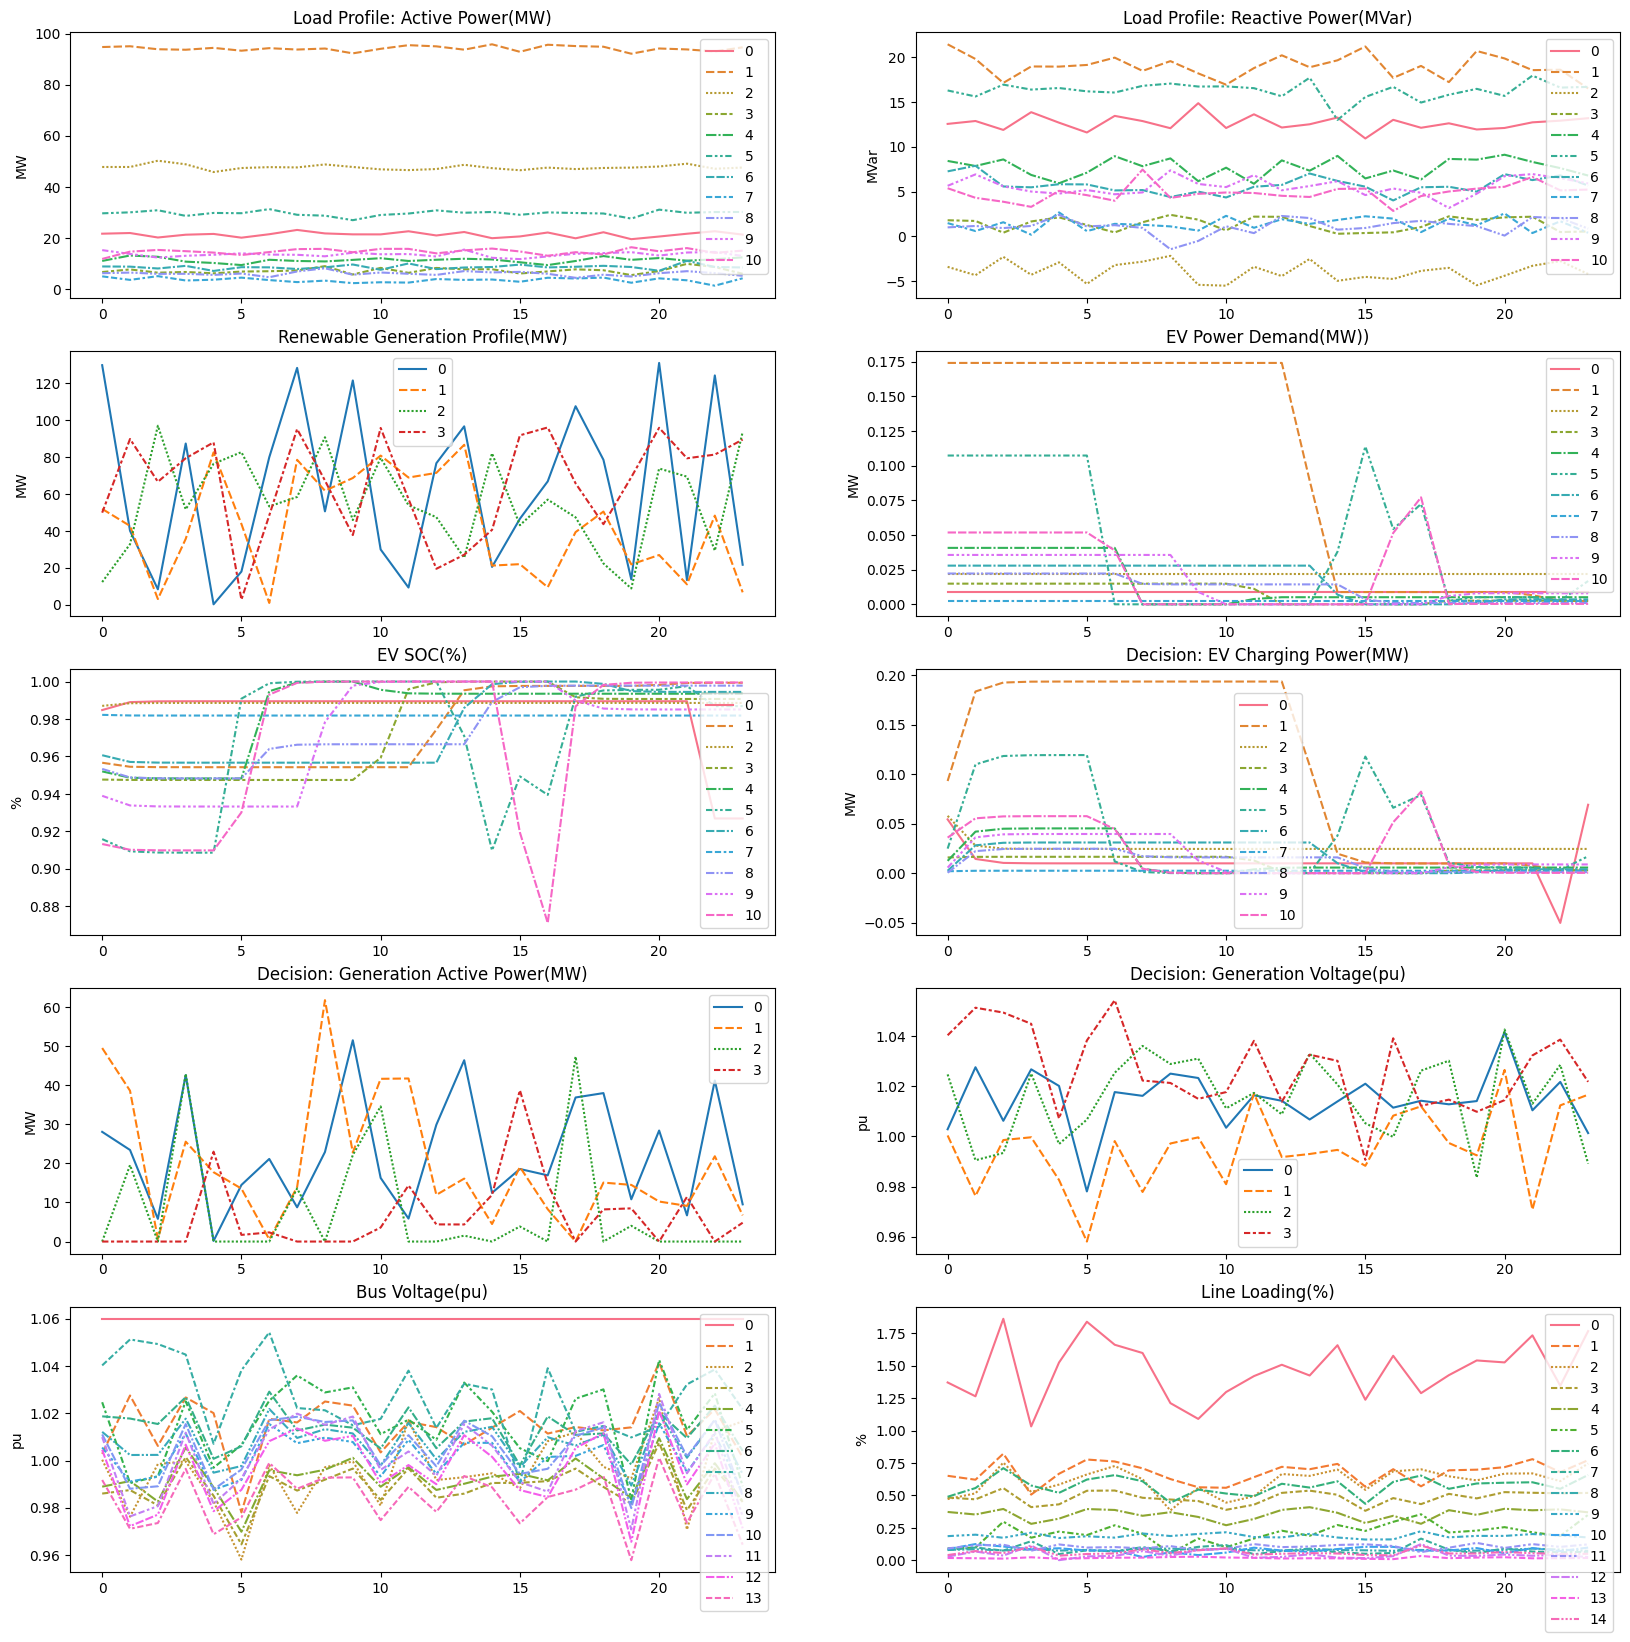

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df_load_p = pd.read_csv("../Evaluation/Case14_EV/load_p.csv")
df_load_q = pd.read_csv("../Evaluation/Case14_EV/load_q.csv")
df_renew = pd.read_csv("../Evaluation/Case14_EV/renewable.csv")
df_ev_demand = pd.read_csv("../Evaluation/Case14_EV/ev_demand.csv")
df_ev_soc = pd.read_csv("../Evaluation/Case14_EV/ev_soc.csv")
df_gen_p = pd.read_csv("../Evaluation/Case14_EV/gen_p.csv")
df_gen_v = pd.read_csv("../Evaluation/Case14_EV/gen_v.csv")
df_ev_action = pd.read_csv("../Evaluation/Case14_EV/ev_action.csv")
df_voltage = pd.read_csv("../Evaluation/Case14_EV/voltage.csv")
df_line_loading = pd.read_csv("../Evaluation/Case14_EV/line_loading.csv")

#define plotting region (5 rows, 5 columns)
fig, axes = plt.subplots(5, 2,figsize=(20,20))
sns.lineplot(data=df_load_p, ax=axes[0,0])
sns.lineplot(data=df_load_q, ax=axes[0,1])
sns.lineplot(data=df_renew, ax=axes[1,0])
sns.lineplot(data=df_ev_demand, ax=axes[1,1])
sns.lineplot(data=df_ev_soc, ax=axes[2,0])
sns.lineplot(data=df_ev_action, ax=axes[2,1])
sns.lineplot(data=df_gen_p, ax=axes[3,0])
sns.lineplot(data=df_gen_v, ax=axes[3,1])
sns.lineplot(data=df_voltage, ax=axes[4,0])
sns.lineplot(data=df_line_loading, ax=axes[4,1])

axes[0,0].set_title("Load Profile: Active Power(MW)")
axes[0,1].set_title("Load Profile: Reactive Power(MVar)")
axes[1,0].set_title("Renewable Generation Profile(MW)")
axes[1,1].set_title("EV Power Demand(MW))")
axes[2,0].set_title("EV SOC(%)")
axes[2,1].set_title("Decision: EV Charging Power(MW)")
axes[3,0].set_title("Decision: Generation Active Power(MW)")
axes[3,1].set_title("Decision: Generation Voltage(pu)")
axes[4,0].set_title("Bus Voltage(pu)")
axes[4,1].set_title("Line Loading(%)")


# axes.set_xlabel("Hour")
axes[0,0].set_ylabel("MW")
axes[0,1].set_ylabel("MVar")
axes[1,0].set_ylabel("MW")
axes[1,1].set_ylabel("MW")
axes[2,0].set_ylabel("%")
axes[2,1].set_ylabel("MW")
axes[3,0].set_ylabel("MW")
axes[3,1].set_ylabel("pu")
axes[4,0].set_ylabel("pu")
axes[4,1].set_ylabel("%")

In [25]:
df = pd.read_csv("../Data/German_EV/emobpy_timeseries_hourly.csv")
df.head()

/var/folders/w4/7lpv40nd2g79_r3by73bjd7c0000gn/T/ipykernel_795/2004322136.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/German_EV/emobpy_timeseries_hourly.csv")


,Unnamed: 0,ID,VehicleMobility,DrivingConsumption,GridAvailability,GridDemand_Immediate_full_capacity,GridDemand_Immediate_full_capacity.1,GridDemand_Immediate_balanced,GridDemand_Immediate_balanced.1,GridDemand_From_0_to_24_at_home,GridDemand_From_0_to_24_at_home.1,GridDemand_From_23_to_8_at_home,GridDemand_From_23_to_8_at_home.1
0,NaN,ID,Distance_km,Consumption_kWh,PowerRating_kW,Load_kW,SoC,Load_kW,SoC,Load_kW,SoC,Load_kW,SoC
1,date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:00:00,0.0,0.0,0.0,3.7,3.7,0.546,0.426,0.50525,0.426,0.50525,0.426,0.50525
3,2020-01-01 01:00:00,0.0,0.0,0.0,3.7,3.7,0.62,0.426,0.514,0.426,0.514,0.426,0.514
4,2020-01-01 02:00:00,0.0,0.0,0.0,3.7,3.7,0.694,0.426,0.5222500000000001,0.426,0.5222500000000001,0.426,0.5222500000000001


In [26]:
# df = pd.read_csv("../Data/German_EV/emobpy_timeseries_original.csv")
# Modify column names by appending the content of the first row
new_column_names = [f"{col}_{df.at[0, col]}" for col in df.columns]

# Assign the new column names to the DataFrame
df.columns = new_column_names

# Drop the first and second rows
df = df.drop([0, 1]).reset_index(drop=True)

# Define a conversion function to convert values into float or int
def convert_to_float_int(value):
    try:
        # Try to convert to float
        float_val = float(value)
        # If the float value is equivalent to an int, return as int
        if float_val.is_integer():
            return int(float_val)
        else:
            return float_val
    except ValueError:
        # Return the original value if conversion fails
        return value

# Apply the conversion function to each element in the DataFrame
df = df.map(convert_to_float_int)
df = df.rename(columns={"Unnamed: 0_nan":"Time", 
                        "ID_ID":"ID",
                        "VehicleMobility_Location":"Location",
                        "VehicleMobility.1_Distance_km":"Distance_km", 
                        "DrivingConsumption_Consumption_kWh":"DrivingConsumption_kWh",
                        "GridAvailability_ChargingStation":"ChargingStation",
                        "GridAvailability.1_PowerRating_kW":"ChargingAvailability_kW",
                        "GridDemand_Immediate_full_capacity_Load_kW":"ChargingPowerImmediateFull_kW",
                        "GridDemand_Immediate_full_capacity.1_SoC":"SOCImmediateFull",
                        "GridDemand_Immediate_balanced_Load_kW":"ChargingPowerImmediateBalanced_kW",
                        "GridDemand_Immediate_balanced.1_SoC":"SOCImmediateBalanced",
                        "GridDemand_From_0_to_24_at_home_Load_kW":"ChargingPowerHome_kW",
                        "GridDemand_From_0_to_24_at_home.1_SoC":"SOCHome",
                        "GridDemand_From_23_to_8_at_home_Load_kW":"ChargingPowerNight_kW",
                        "GridDemand_From_23_to_8_at_home.1_SoC":"SOCNight"})
# df = df[df["ID"] < net.load.index.size]
df = df[df["ID"] < 11]
df['Time'] = pd.to_datetime(df['Time'])
df["Time_step"] = (df['Time'].astype('int64') - df['Time'].astype('int64').min()) // (3600 * 10**9)

NameError: name 'net' is not defined

In [ ]:
df_multiIndexed = df.set_index(['ID', 'Time_step'])
df_multiIndexed

Time  VehicleMobility_Distance_km  \
ID Time_step                                                    
0  0         2020-01-01 00:00:00                          0.0   
   1         2020-01-01 01:00:00                          0.0   
   2         2020-01-01 02:00:00                          0.0   
   3         2020-01-01 03:00:00                          0.0   
   4         2020-01-01 04:00:00                          0.0   
...                          ...                          ...   
10 8755      2020-12-30 19:00:00                          0.0   
   8756      2020-12-30 20:00:00                          0.0   
   8757      2020-12-30 21:00:00                          0.0   
   8758      2020-12-30 22:00:00                          0.0   
   8759      2020-12-30 23:00:00                          0.0   

              DrivingConsumption_kWh  GridAvailability_PowerRating_kW  \
ID Time_step                                                            
0  0                             0.0                              3.7   
   1                             0.0                              3.7   
   2                             0.0                              3.7   
   3                             0.0                              3.7   
   4                             0.0                              3.7   
...                              ...                              ...   
10 8755                          0.0                              3.7   
   8756                          0.0                              3.7   
   8757                          0.0                              3.7   
   8758                          0.0                              3.7   
   8759                          0.0                              3.7   

              ChargingPowerImmediateFull_kW  SOCImmediateFull  \
ID Time_step                                                    
0  0                                    3.7             0.546   
   1                                    3.7             0.620   
   2                                    3.7             0.694   
   3                                    3.7             0.768   
   4                                    3.7             0.842   
...                                     ...               ...   
10 8755                                 0.0             1.000   
   8756                                 0.0             1.000   
   8757                                 0.0             1.000   
   8758                                 0.0             1.000   
   8759                                 0.0             1.000   

              ChargingPowerImmediateBalanced_kW  SOCImmediateBalanced  \
ID Time_step                                                            
0  0                                      0.426               0.50525   
   1                                      0.426               0.51400   
   2                                      0.426               0.52225   
   3                                      0.426               0.53100   
   4                                      0.426               0.53925   
...                                         ...                   ...   
10 8755                                   0.867               0.92525   
   8756                                   0.867               0.94225   
   8757                                   0.867               0.95950   
   8758                                   0.867               0.97650   
   8759                                   0.867               0.99350   

              ChargingPowerHome_kW  SOCHome  ChargingPowerNight_kW  SOCNight  
ID Time_step                                                                  
0  0                         0.426  0.50525                  0.426   0.50525  
   1                         0.426  0.51400                  0.426   0.51400  
   2                         0.426  0.52225                  0.426   0.52225  
   3                         0.426  0.531

In [4]:
def convertTuple(tup):
    str = '_'.join(tup)
    return str
for i in profiles.keys():
    a = convertTuple(i)
    if a == 'load_p_mw':
        load_pmw = profiles[i]
    elif a == 'load_q_mvar':
        load_qmvar = profiles[i]